# `Практикум по программированию на языке Python`

## `Задание 1.5. Классификация изображений`.

#### Фамилия, имя: Богачев Владимир

Дата выдачи: <span style="color:red">__5 марта__</span>.

Мягкий дедлайн: <span style="color:red">__12 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __3 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt

random_seed = 0
torch.manual_seed(random_seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## `Задание 1. Загрузка данных (0.5 балла)`

В этой домашке работа с данными будем максимально облегчённой. Мы скачаем MNIST с помощью [стандартных средств](https://pytorch.org/vision/0.8/datasets.html#mnist) торча. Посмотреть список других доступных датасетов можно [здесь](https://pytorch.org/vision/0.8/datasets.html).

In [2]:
def load_mnist(train, transform=None):    
    if transform is None:
        transform = T.ToTensor()
    # print(transform)
    return torchvision.datasets.MNIST(
        root='./data',
        train=train,
        transform=transform,
        download=True
    )

Пиксели изображений принимают значения [0,1]. Скачайте датасет и посчитайте выборочное среднее и выборочное стандартное отклонение для значения пикселя. Т.е. должно получиться число `mean` для среднего, и число `std` для стандартного отклонения.

*Подсказка.* Подумайте, на какой части датасета нужно считать эти статистики (обучение или валидация), чтобы предотвратить утечку данных.

*Подсказка.* У торч датасета реализован метод `__getitem__`, т.е. его можно индексировать `dataset[i]`.

In [3]:
norm_transform = T.Compose([
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float32)
])

data_train = load_mnist(True, transform=norm_transform)

X_train = torch.stack([data_train[i][0] for i in range(len(data_train))])
# y_train = data_train.targets

print(X_train.dtype, X_train.shape)

mean =  torch.mean(X_train)
std =  torch.std(X_train)
print(f"mean = {mean:.2f}, std = {std:.2f}")

torch.float32 torch.Size([60000, 1, 28, 28])
mean = 0.13, std = 0.31


Полученные значения можно применить для нормализации изображений, когда будем подавать их в нейросеть.

In [4]:
norm_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_mnist = load_mnist(True, norm_transform)
val_mnist = load_mnist(False, norm_transform)

In [5]:
X_train = torch.stack([train_mnist[i][0] for i in range(len(train_mnist))])
y_train = train_mnist.targets

X_val = torch.stack([val_mnist[i][0] for i in range(len(val_mnist))])
y_val = val_mnist.targets

X_train.shape, X_train.dtype, X_val.shape, X_val.dtype

(torch.Size([60000, 1, 28, 28]),
 torch.float32,
 torch.Size([10000, 1, 28, 28]),
 torch.float32)

Во время обучения данные подаются в нейросеть батчами.

Обычно batch_size выбирается так, чтобы во время обучения получалась меньше дисперсия градиента (ну вы уже знакомы с sgd), также часто batch_size выбирается максимально возможным по ресурсам.

Для этой задачи нам хватит batch_size = 64 во время обучения.

*Ответьте на вопрос:* Почему в большинстве задач для валидации и тестирования можно выбирать batch_size больше? 

In [6]:
from torch.utils.data import DataLoader

batch_size_train = 64
batch_size_test = 1000

train_mnist_loader = DataLoader(
    dataset=train_mnist,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True
)

val_mnist_loader = torch.utils.data.DataLoader(
    dataset=val_mnist,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False
)

In [7]:
images, labels = next(iter(train_mnist_loader))
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

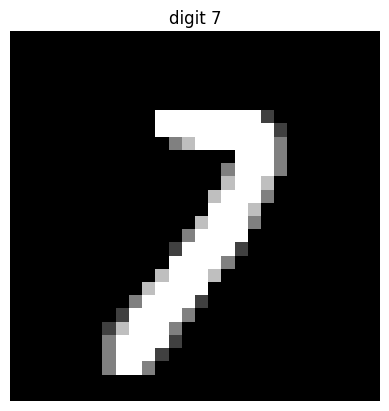

In [8]:
i = 3
plt.title(f'digit {labels[i]}')
plt.imshow(images[i, 0], cmap='gray')
plt.axis('off')
plt.show()

## `Задание 2. Цикл обучения (1.5 балла)`

Ниже предоставлен базовый вариант цикла обучения, представленный тремя функциями: `train_epoch`, `val_epoch`, `train_val`.

In [9]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels, reduction='mean')
        loss.backward()
        optimizer.step()

In [10]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels, reduction='sum').item()
        pred = torch.argmax(logits, dim=1)
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

In [11]:
def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
):
    """full cycle of neural network training"""

    val_epoch(network, val_loader, criterion)
    for epoch in range(1, n_epochs + 1):
        train_epoch(network, train_loader, criterion, optimizer)
        val_epoch(network, val_loader, criterion)

Для проверки, что все работает, обучите бейзлайн -- однослойную [полносвязную](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) сеть на [кросс-энтропийный лосс](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). 


*Заметьте*, что на вход этому лоссу нужно подавать сырой выход нейросети, а не результат применения софтмакса.

In [15]:
class LogReg(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.input_size = input_size
        self.linear = nn.Linear(in_features=input_size, out_features=output_size)

    def forward(self, x):
        print(x.shape)
        x = self.linear(x.view(-1, 1, self.input_size))

        return x

In [16]:
# X_train = X_train.reshape(-1, 28 * 28).to(device)
# X_val = X_val.reshape(-1, 28 * 28).to(device)

In [18]:
model = LogReg(X_train.shape[1] * X_train.shape[2], 10).to(device)

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    train_loader=train_mnist_loader,
    val_loader=val_mnist_loader,
    n_epochs=10,
)

torch.Size([1000, 1, 28, 28])


ValueError: Expected input batch_size (28000) to match target batch_size (1000).

Test set: Avg. loss: 2.4114 Accuracy: 843/10000 (8%)
Test set: Avg. loss: 0.2837 Accuracy: 9179/10000 (92%)
Test set: Avg. loss: 0.2796 Accuracy: 9201/10000 (92%)
Test set: Avg. loss: 0.2812 Accuracy: 9199/10000 (92%)

## `Задание 3. Логирование (3 балл)`

Скопируйте и перепишите функции `train_epoch`, `val_epoch`, `train_val` таким образом, чтобы
- во время обучения раз в `logging_interval` шагов оптимизации выводились лосс и аккураси на одном батче (пример ниже, но не обязательно делать идентично)
- происходило сохранение весов лучшей (по аккураси на валидации) модели и состояния оптимизатора ([в помощь](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended))
- в конце обучения выводился и сохранялся график-саммари (пример ниже, но не обязательно делать идентично)

*Ответьте на вопрос:* Что хранится в состоянии оптимизатора? Зачем нужно его сохранять? Приведите хотя бы один пример оптимизатора, для которого есть смысл сохранять состояние.

In [ ]:
# your training functions are here

In [ ]:
# here you start training

Загрузите лучшие веса модели и подсчитайте аккураси на валидации, чтобы подтвердить что веса сохранились корректно.

In [ ]:
# your code is here

Загрузите сохранённое состояние оптимизатора и сделайте две эпохи обучения, чтобы подтвердить, что состояния оптимизатора были сохранены корректно.

In [ ]:
# your code is here

## `Задание 4. Логирование с помощью tensorboard (1 балл)`

На самом деле это дурной тон логировать обучение нейросети так, как это сделали вы выше. Дело в том, что весь функционал уже реализован в [`tensorboard`](https://pytorch.org/docs/stable/tensorboard.html), а вы написали велосипед.

In [ ]:
! pip3 install tensorboard
from torch.utils.tensorboard import SummaryWriter

Если у вас есть доступ к терминалу и браузеру, то удобнее всего ввести команду
```bash
tensorboard --logdir .
```
и открыть UI в выделенном локалхосте. 

Если вы работаете в гугл колабе, то можете запустить UI как виджет в Jupyter:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir .

Как только вы начнете логировать в объект типа `SummaryWriter`, в UI начнут строиться кривые обучения.

Скопируйте и перепишите функции обучения таким образом, чтобы логирование происходило в `tensorboard`.

*Замечание.* Вам пригодится метод `add_scalar`, чтобы сохранять лосс и аккураси, и метод `add_hparams`, чтобы сохранить важные гиперпараметры (например, кодовое имя архитектуры сети) и финальное достигнутое качество.

In [ ]:
# your training functions are here

## `Задание 5. Побейте бейзлайн (2+2 балла)`

На датасете [`CIFAR-10`](https://pytorch.org/vision/0.8/datasets.html#torchvision.datasets.CIFAR10) обучите модель, которая выдает аккураси `>=0.7` (2 балла) и аккураси `>=0.8` (ещё 2 балла).
- Можете использовать любые модули `pytorch`, любые оптимизаторы и шедулеры, можете использовать аугментации ([например](https://pytorch.org/vision/stable/transforms.html))
- Для отслеживания экспериментов используйте логирование с `tensorboard`, не забывайте давать осмысленные имена эспериментам и логировать нужные гиперпараметры, сохранять веса сети и состояние оптимизатора.

In [ ]:
# your code is here

## `Бонус. Побейте бейзлайн (3 балла)`

На датасете `CIFAR-10` обучите модель, которая выдает аккураси `>=0.9`.

In [ ]:
# your code is here